In [76]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
import matplotlib.pyplot as plt
from typing import List
from plot_config import *

In [77]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])

### First-Order Product Formula (PF1)

We can decompose the Hamiltonian as:

$
H = \sum_{l=1}^L H_l = \sum_{l=1}^L c_l P_l
$

where:
- $c_l \in \mathbb{R}$ are the coefficients,
- $P_l$ are Pauli words (tensor products of Pauli matrices).

The ideal time evolution operator is:
$
U(t) = e^{-i H t}
$

The first-order Trotter approximation replaces this by sequentially applying each term:
$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t}
$


### Second-order Product Formulas (PF2) 
The second-order approximation is a combination of evolutions in both increasing and decreasing orders of indice. 
More formally, we can write this as: 

$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t / 2} \prod_{l} e^{-i H_l \, \delta t / 2}  
$

- Each term $H_l$ is applied twice with a half-step $\delta t / 2$.
- The first product applies the exponentials in increasing order of $l$.
- The second product applies them in decreasing order of $l$.

The following code creates the model that was used in the paper: **QIMF** 

The hamiltonian is defined as the following: 

$
H \;=\; 
h_x \sum_{j=1}^N X_j \;+\;
h_y \sum_{j=1}^N Y_j \;+\;
J \sum_{j=1}^{N-1} X_j X_{j+1}
$

- $X_j, Y_j, Z_j$: Pauli operators on qubit \(j\).


In [16]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):
    A = 0 
    B = 0
    for j in range(n_spins - 1):
        A += J * spin.x(j) * spin.x(j + 1) 
        
    for j in range(n_spins):
        A += h_x * spin.x(j)
        B += h_y * spin.y(j)
        
    return A, B, A+B

### Trotter Approximation (PF1) 
The time-evolution operator 
$
e^{-i H \delta t}
$
 can be split into two non-commuting parts:

$
A = h_x \sum_j X_j \;+\; J \sum_j X_j X_{j+1}, 
\qquad
B = h_y \sum_j Y_j
$

so that the first-order Trotter step is:

$
\mathcal{U}_1(\delta t) \;\approx\; e^{-i A \delta t} \, e^{-i B \delta t}
$ 

In [72]:
@cudaq.kernel 
def trotter_step_pf1 (state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    qubits = cudaq.qvector(state)
    
    for i in range(len(c_a)):
        exp_pauli(c_a[i].real * dt, qubits, words_a[i])
        
    for i in range(len(c_b)):
        exp_pauli(c_b[i].real * dt, qubits, words_b[i])
        

### Trotter Approximation (PF2) 
Similar to PF1, we can define 

$
U(\delta t) \;\approx\; 
e^{-i A \, \tfrac{\delta t}{2}} \,
e^{-i B \, \delta t} \,
e^{-i A \, \tfrac{\delta t}{2}}
$

We apply all A-terms again with half timestep $\delta t / 2$, in reverse order for symmetry.

In [40]:
@cudaq.kernel
def trotter_step_pf2(state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    
    qubits = cudaq.qvector(state)
    
    for i in range(len(words_a)):
        exp_pauli(c_a[i].real * (0.5*dt), qubits, words_a[i])
        
    for i in range(len(words_b)):
        exp_pauli(c_b[i].real * dt, qubits, words_b[i])
        
    for i in range(len(words_a)-1, -1, -1):
        exp_pauli(c_a[i].real * (0.5*dt), qubits, words_a[i])


Here, we extract coefficients and words from Hamiltonian for decomposition. 

In [8]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

### Entropy Measure

Given a pure state $|\psi\rangle$ of an $n$-qubit system, the reduced density matrix for a subset of qubits $A$ is

$
\rho_A = \mathrm{Tr}_B \big( |\psi\rangle \langle \psi | \big),
$

where $B$ is the set of qubits traced out.

We can quantify its entanglement with the rest of the system by calculating von Neumann entropy:

$S(\rho) = - \text {Tr} [\rho \log \rho] = - \sum_i \lambda_i \log_2 \lambda_i$

where $\lambda_i$ are the eigenvalues of the reduced density matrix.

In [58]:
def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [59]:
def entropy(rho):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]  
    return -np.sum(eigvals * np.log2(eigvals))

In [60]:
def purity(rho):
    return cp.real(cp.trace(rho @ rho)).item() 

In [73]:
def simulation_typical (n_spins: int, cal: str, sub: int, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0): 
    n = n_spins
    state = initial_state
    out_list = []
    time_list = []

    dt = 0.1
    subsystem = list(range(sub)) 

    h_x = np.full(n_spins, h_x_val) 
    h_y = np.full(n_spins, h_y_val) 
    h_z = np.zeros(n_spins)
    J = 1.0 

    A, B, H = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    
    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)

    start_time = time.time()
    for step in range(1, r + 1): 
        state = cudaq.get_state(trotter_step_pf1, state, dt, c_a, c_b, words_a, words_b)
        psi = cp.array(state)
        rho_A = partial_trace (psi, subsystem, n_qubits=n_spins)
        
        if cal == 'purity':
            S = purity(rho_A)
        elif cal == 'entropy':
            S = entropy(rho_A)
        else:
            print('invalid input') 
            return 1 
            
        out_list.append(S)
        time_list.append(dt * step)
    
    total_time = time.time() - start_time
    print(f"Simulation for subsystem {len(subsystem)} done in {total_time:.2f} seconds")
    out_np = np.array([x.get() if hasattr(x, 'get') else x for x in out_list])
    
    return out_np, subsystem

/tmp/ipykernel_1033754/722446967.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


Simulation for subsystem 1 done in 0.25 seconds
Simulation for subsystem 2 done in 0.20 seconds
Simulation for subsystem 3 done in 0.19 seconds
Simulation for subsystem 4 done in 0.20 seconds


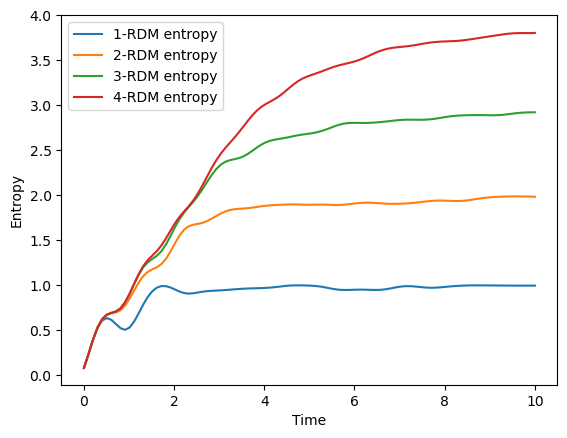

In [74]:
n = 12 
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 4 
t_list = np.linspace(0, 10, 100) 

for i in range(1, subsystem + 1):
    n_12_p, sub_12_p = simulation_typical(n, 'entropy', i, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
    plt.plot(t_list, n_12_p, label=f'{i}-RDM entropy')

plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])

plt.legend()
plt.xlabel('Time')
plt.ylabel('Entropy') 
plt.show()

/tmp/ipykernel_1033754/722446967.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


Simulation for subsystem 1 done in 1.12 seconds
Simulation for subsystem 2 done in 1.09 seconds
Simulation for subsystem 3 done in 1.08 seconds
Simulation for subsystem 4 done in 1.08 seconds
Simulation for subsystem 5 done in 1.08 seconds
Simulation for subsystem 6 done in 1.15 seconds


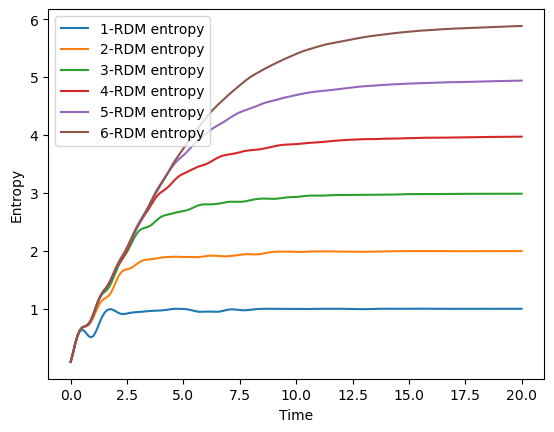

In [75]:
n = 20
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 6
t_list = np.linspace(0, 20, 200) 
r = 200

for i in range(1, subsystem + 1):
    n_12_p, sub_12_p = simulation_typical(n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0) 
    plt.plot(t_list, n_12_p, label=f'{i}-RDM entropy')

plt.yticks([1, 2, 3, 4, 5, 6])  

plt.legend()
plt.xlabel('Time')
plt.ylabel('Entropy') 
plt.show()